# Project 3
The prediction of molecular properties is an important task in drug discovery. The molecules' atomic composition and arrangement can already tell us a lot about their biological behavior. Each 2D molecule can be represented as a graph, where the nodes are atoms connected by edges corresponding to chemical bonds. The prediction of molecular properties can be formulized as a graph classification task, and graph neural network is usually applied for making graph-level prediction.

In this project, you need develop a model for predicting the toxicity of new molecules. This notebook provides a sample pipeline that establishes a baseline. It is expected that your methods should outperform this baseline. You are strongly encouraged to think about designing more powerful models, finetuning hyperparameters, developing better training strategies, etc.

# Install package

In [25]:
# New these two packages
%pip install torch_geometric
%pip install rdkit-pypi
%pip install torch 
%pip install molvs
%pip install pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Some tutorials.



1.   Pytorch geometric package: https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html
2.   PyTorch Geometric for Graph-Based Molecular Property Prediction using MoleculeNet benchmark: https://medium.com/@nikopavl4/pytorch-geometric-for-graph-based-molecular-property-prediction-using-moleculenet-benchmark-41e36369d3c6
3. Graph neural networks for graph classification. https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb?usp=sharing
4. Related github repository on molecular property predictions. https://github.com/yifeiwang15/MotifConv/tree/main/MCM_for_molecule_benchmarks


## What are node and edge features in a molecule.

### Node features:

**Atomic number**: Number of protons in the nucleus of an atom. It’s characteristic of a chemical element and determines its place in the periodic table.

**Chirality**: A molecule is chiral if it is distinguishable from its mirror image by any combination of rotations, translations, and some conformational changes. Different types of chirality exist depending on the molecule and the arrangement of the atoms.

**Degree**: Number of directly-bonded neighbors of the atom.
Formal charge: Charge assigned to an atom. It reflects the electron count associated with the atom compared to the isolated neutral atom.

**Number of H**: Total number of hydrogen atoms on the atom.
Number of radical e: Number of unpaired electrons of the atom.

**Hybridization**: Atom’s hybridization.

**Is aromatic**: Whether it is included in a cyclic structure with pi bonds. This type of structure tends to be very stable in comparison with other geometric arrangements of the same atoms.

**Is in ring**: Whether it is included in a ring (a simple cycle of atoms and bonds in a molecule).

### Edge features:

**Bond type:**: Whether the bond is single, double, triple, or aromatic.

**Stereo Type:** Stereo configuration of the bond.

**Is conjugated**: Whether or not the bond is considered to be conjugated.



# Dataset preparation and train-valid splitting.

In [26]:
import torch
import torch_geometric
import numpy as np
from torch_geometric.data import Data
from torch_geometric.data import DataLoader
from torch_geometric.datasets import MoleculeNet
import pickle

In [27]:
# Load datasets. The training and validation sets contain both molecules and their property labels. The test set only contain molecules.
# There are 12 property tasks for prediction. Some properties labels are missing (i.e., nan). You can ignore them.
train_dataset = torch.load("train_data.pt")
valid_dataset = torch.load("valid_data.pt")
# test_dataset = torch.load("test_data.pt")

print(f'Size of training set: {len(train_dataset)}')
print(f'Size of validation set: {len(valid_dataset)}')
# print(f'Size of test set: {len(test_dataset)}')

Size of training set: 6264
Size of validation set: 783


In [28]:
# one graph example
g = train_dataset[1]
print(g)

print("Get node feature matrix:")
print(g.x)
print(g.x.shape) # (num_of_nodes, num_of_node_features)

print("Get edge index matrix:")
print(g.edge_index)
print(g.edge_index.shape) # (2, num_of_edges)

print("Get edge attribute matrix:")
print(g.edge_attr)
print(g.edge_attr.shape) # (num_of_edges, num_of_edge_features)

print("Get molecular property labels:")
print(g.y)
print(g.y.shape) # (1, 12)

Data(x=[20, 9], edge_index=[2, 38], edge_attr=[38, 3], y=[1, 12], smiles='CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C')
Get node feature matrix:
tensor([[6, 0, 4, 5, 3, 0, 4, 0, 0],
        [6, 0, 4, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 3, 0, 4, 0, 0],
        [6, 0, 4, 5, 3, 0, 4, 0, 0],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 3, 0, 4, 0, 0],
        [6, 0, 4, 5, 3, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 2, 0, 4, 0, 0],
        [6, 0, 4, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 3, 0, 4, 0, 0],
        [6, 0, 4, 5, 3, 0, 4, 0, 0],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [8, 0, 2, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 0, 0, 4, 0, 0],
        [6, 0, 4, 5, 3, 0, 4, 0, 0],
        [6, 0, 4, 5, 3, 0, 4, 0, 0],
        [6, 0, 4, 5, 3, 0, 4, 0, 0]])
torch.Size([20, 9])
Get edge index matrix:
tensor([[ 0,  1,  1,  1,  1,  2,  3,  4,  4,  5,  5,  6,  6,  6,  6,  7,  8,  

As we can observe, we have 11 nodes (rows) and each node has 9 features (columns). However, the features provided by Moleculenet are discrete and of type long, so we need to convert them first to continuous embeddings in order to feed them in any ML model.

For example, the first column indicates the atomic number of a node, where 1 represents Hydrogen, 6 represents Carbon, 8 for Oxygen, according to periodic table of elements.

In [29]:
# Example of preparing data loaders.
# You can use any batch size and see what happens in model performance.

from torch_geometric.data import DataLoader

batch_size=32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

/Users/nguyenv/Desktop/project-3/.venv/lib/python3.11/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [30]:
# Example of creating one mini-batch
# See more info about mini-batch in pytorch geometric in https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html
batch = next(iter(train_loader))
print(batch)

DataBatch(x=[465, 9], edge_index=[2, 920], edge_attr=[920, 3], y=[32, 12], smiles=[32], batch=[465], ptr=[33])


# Visualization of molecules

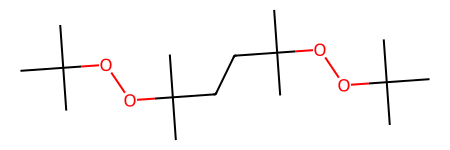

In [31]:
# visualize one 2D molecule.
from rdkit import Chem
Chem.MolFromSmiles(g.smiles)

### Calculate weights for each class 

In [32]:
import numpy as np
# Assuming there are 12 properties, initialize an array to store counts for each property
property_counts = np.zeros(12)

# Iterate over the dataset to count each property
for graph in train_dataset:
    labels = graph.y
    for i in range(12):
        if not torch.isnan(labels[0, i]):
            property_counts[i] += labels[0, i]

# Calculate class weights
# The weight for each class is inversely proportional to its frequency
class_weights = [1.0 / count if count > 0 else 0 for count in property_counts]
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Handle the case where a class is not present in the dataset (to avoid division by zero)
class_weights[class_weights == float('inf')] = 0

print("Class weights:", class_weights)

Class weights: tensor([0.0040, 0.0053, 0.0017, 0.0048, 0.0015, 0.0034, 0.0075, 0.0014, 0.0051,
        0.0035, 0.0014, 0.0036])


### Calculate weights for each class after adding minority class

In [33]:
import torch.nn.functional as F

def weighted_binary_cross_entropy(output, target, weights=None):
    if weights is not None:
        # Apply weights to the loss
        loss = torch.nn.BCEWithLogitsLoss(pos_weight=weights)(output, target)
        return loss.mean()
        
    else: loss = F.binary_cross_entropy(output, target, reduction='none')

    return torch.mean(torch.sum(loss, dim=1))

In [34]:
# Example of preparing data loaders.
# You can use any batch size and see what happens in model performance.

from torch_geometric.loader import DataLoader

batch_size=32

new_train_dataset = []	
 # Remove data that has nan values
for data in train_dataset:
    y = data.y.numpy()
    has_nan = np.isnan(y).any()
    if not has_nan:
        new_train_dataset.append(data)
        
print(f"Original training set size: {len(train_dataset)}")
print(f"New training set size: {len(new_train_dataset)}")
new_train_loader = DataLoader(new_train_dataset, batch_size=batch_size, shuffle=True)

Original training set size: 6264
New training set size: 2706


# Build model

In [35]:
# from rdkit import Chem
# import numpy as np

# atom_features_total = []
# # Function to convert SMILES to molecular graph features
# def smiles_to_graph(smiles):
    
#     for smile in smiles:
#         mol = Chem.MolFromSmiles(smile)

#         # Extract features for each atom
#         atom_features = []
#         for atom in mol.GetAtoms():
#             atom_features.append([atom.GetAtomicNum(),  # Atomic number
#                                 atom.GetDegree(),     # Degree
#                                 atom.GetFormalCharge(),  # Charge
#                                 atom.GetHybridization().real])  # Hybridization

#         # Convert to numpy array or any format suitable for your model
#         atom_features_total.append(np.array(atom_features, dtype=np.float32))

#     return atom_features

In [36]:
# import molvs as mv
# from rdkit import Chem
# from rdkit.Chem import AllChem, rdMolDescriptors

# def parent(smiles):
#     st = mv.Standardizer()
#     try:
#         mols = st.charge_parent(Chem.MolFromSmiles(smiles))
#         return Chem.MolToSmiles(mols)
#     except:
#         return "NaN"

# def morgan_fp(smiles, radius=3, n_bits=8192):
#     standardized_smiles = parent(smiles)
#     if standardized_smiles != "NaN":
#         mol = Chem.MolFromSmiles(standardized_smiles)
#         fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
#         return np.array(list(fp.ToBitString())).astype('int')
#     else:
#         return np.zeros(n_bits, dtype='int')

# # Add fingerprint data to the datasets
# for dataset in [train_dataset, valid_dataset]:
#     for data in dataset:
#         smiles = data.smiles
#         fp_array = morgan_fp(smiles)
#         fp_array = torch.tensor(fp_array, dtype=torch.float)	
#          # Expand fp_array to match the number of nodes in data.x
#         num_nodes = data.x.size(0)
#         fp_array_expanded = fp_array.repeat(num_nodes, 1)  # Repeat for each node
#         data.x = torch.cat((data.x, fp_array_expanded), dim=1)
#         print(data.x.shape)

In [41]:
# Atom encoder
class AtomEncoder(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(AtomEncoder, self).__init__()

        self.embeddings = torch.nn.ModuleList()

        for i in range(9):
            self.embeddings.append(torch.nn.Embedding(100, hidden_channels))

    def reset_parameters(self):
        for embedding in self.embeddings:
            embedding.reset_parameters()

    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(1)

        out = 0
        for i in range(x.size(1)):
            out += self.embeddings[i](x[:, i])
        return out

# A simple graph neural network model
import torch
from torch_geometric.nn import GraphConv, global_mean_pool as gap

import torch.nn.functional as F
from torch.nn import Linear, BatchNorm1d 
from torch_geometric.nn import global_mean_pool

class GNN(torch.nn.Module):
    def __init__(self, hidden_channels, num_classes, dropout_rate, num_node_features=9, fingerprint_dim=8192):
        super(GNN, self).__init__()
        torch.manual_seed(12345)
        self.emb = AtomEncoder(hidden_channels=hidden_channels)
        self.conv1 = GraphConv(hidden_channels, hidden_channels)
        self.bn1 = BatchNorm1d(hidden_channels)
        self.conv2 = GraphConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm1d(hidden_channels)
        self.conv3 = GraphConv(hidden_channels, hidden_channels)
        self.bn3 = BatchNorm1d(hidden_channels)
        self.lin = Linear(hidden_channels, num_classes)
        self.fp_lin = Linear(fingerprint_dim, hidden_channels)
        self.dropout_rate = dropout_rate

    def forward(self, batch):
        x, edge_index, batch_size = batch.x, batch.edge_index, batch.batch
    
        x = self.emb(x)  # Initial embedding
        
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_rate, training=self.training)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        
        x = gap(x, batch_size)  # Global Average Pooling
        x = self.lin(x)  # Linear layer for class prediction

        return x
    

# Start training

In [42]:
# loss function and optimizer
import torch.nn as nn
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss(reduction = "none")
model = GNN(hidden_channels=64, num_classes=12, dropout_rate=0.65, fingerprint_dim=8192)

### Train and Evaluate Functions

In [43]:
# train and eval function
from sklearn.metrics import roc_auc_score
def train(model, device, loader, optimizer):
    model.train()

    for step, batch in enumerate(loader):
        batch = batch.to(device)
        pred = model(batch)
        y = batch.y.view(pred.shape).to(torch.float64)

        ## ignore nan targets (unlabeled) when computing training loss.
        is_labeled = batch.y == batch.y
        y_new = torch.where(torch.isnan(batch.y), torch.tensor(0.0, device=batch.y.device), batch.y)
        loss = criterion(pred.to(torch.float32)[is_labeled], y_new.to(torch.float32)[is_labeled]).mean()
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

def eval(model, device, loader):
    model.eval()
    y_true = []
    y_pred = []
    # For every batch in test loader
    for batch in loader:

        batch = batch.to(device)
        if batch.x.shape[0] == 1:
            pass
        else:
            with torch.no_grad():
                pred = model(batch)

            y_true.append(batch.y.view(pred.shape))
            y_pred.append(pred)

    y_true = torch.cat(y_true, dim = 0).numpy()
    y_pred = torch.cat(y_pred, dim = 0).numpy()
    # Compute the ROC - AUC score and store as history
    rocauc_list = []

    for i in range(y_true.shape[1]):
        #AUC is only defined when there is at least one positive data.
        if np.sum(y_true[:,i] == 1) > 0 and np.sum(y_true[:,i] == 0) > 0:
            # ignore nan values
            is_labeled = y_true[:,i] == y_true[:,i]
            rocauc_list.append(roc_auc_score(y_true[is_labeled,i], y_pred[is_labeled,i]))

    if len(rocauc_list) == 0:
        raise RuntimeError('No positively labeled data available. Cannot compute ROC-AUC.')

    return {'rocauc': sum(rocauc_list)/len(rocauc_list)}
    

### Training Loop and functions

In [45]:
# Training function
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Define best_metric as a global variable outside the function
best_metric = 0.801
# model = GNN(hidden_channels=128, num_classes=12, dropout_rate=0.6, fingerprint_dim=8192)
# model.load_state_dict(torch.load("model7898.pt"))

def run_model(model):
    global best_metric  # Declare best_metric as global to modify it inside this function
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    print("Start training...")
    for epoch in range(1, 10000):
        print("====epoch " + str(epoch))

        # training
        train(model, device, train_loader, optimizer)
        # evaluating
        train_acc = eval(model, device, train_loader)
        val_acc = eval(model, device, val_loader)

        if val_acc["rocauc"] > best_metric:
            best_metric = val_acc["rocauc"]
            torch.save(model.state_dict(), "model.pth")
            print(f"Best Epoch: {epoch}")

        print({'Train': train_acc, 'Validation': val_acc})

    return best_metric, model

metric, model = run_model(model)
print(f"Best Metric: {metric}")
torch.save(model.state_dict(), "model.pt")

Start training...
====epoch 1
{'Train': {'rocauc': 0.9569671700504877}, 'Validation': {'rocauc': 0.7988309081677826}}
====epoch 2
{'Train': {'rocauc': 0.9573474963874086}, 'Validation': {'rocauc': 0.7966779168893815}}
====epoch 3
{'Train': {'rocauc': 0.956903772111244}, 'Validation': {'rocauc': 0.7957915941829831}}
====epoch 4
{'Train': {'rocauc': 0.9568231685802084}, 'Validation': {'rocauc': 0.7949541618308387}}
====epoch 5
{'Train': {'rocauc': 0.9568762384723954}, 'Validation': {'rocauc': 0.7940900336288134}}
====epoch 6
{'Train': {'rocauc': 0.9569779940284397}, 'Validation': {'rocauc': 0.7953444231387249}}
====epoch 7
{'Train': {'rocauc': 0.9566120995584128}, 'Validation': {'rocauc': 0.7933165072158669}}
====epoch 8
{'Train': {'rocauc': 0.9568447964820995}, 'Validation': {'rocauc': 0.7970558662241934}}
====epoch 9
{'Train': {'rocauc': 0.9569235327824658}, 'Validation': {'rocauc': 0.7939692317065559}}
====epoch 10
{'Train': {'rocauc': 0.9570395043851376}, 'Validation': {'rocauc': 0.7

In [ ]:
#! For test
# Load the trained model

import pandas as pd
model = GNN(hidden_channels=128, num_classes=12, dropout_rate=0.6, fingerprint_dim=8192)
model.load_state_dict(torch.load("model7898.pt"))
model.eval()

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

# Function to get predictions
def get_predictions(model, loader):
    model.eval()
    predictions = []

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            pred = model(batch)
            pred = torch.sigmoid(pred)  # Apply sigmoid to get probabilities
            predictions.append(pred.cpu().numpy())

    return np.vstack(predictions)

# Get predictions for the test set
test_predictions = get_predictions(model, test_loader)

# Save to CSV file
pd.DataFrame(test_predictions).to_csv("test_output.csv", index=False, header=False)

FileNotFoundError: [Errno 2] No such file or directory: 'model7898.pt'